# Quickstart


`AutoEmulate`'s goal is to make it easy to find a good emulator model for your simulation. Here's the basic workflow:

In [1]:
import numpy as np
from autoemulate.compare import AutoEmulate
from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.projectile import simulator

/Users/mstoffel/turing/projects/autoemulate/autoemulate/compare.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Experimental design

Before we build an emulator or surrogate model, we need to get a set of input/output pairs from the simulation. This is called the **experimental design** and is currently not a key part of `AutoEmulate`, because this step is tricky to automate. There are lots of sampling techniques, but here we are using Latin Hypercube Sampling.   

Below, `simulator` is a simulation for a projectil motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). It takes two inputs, the drag coefficient (on a log scale) and the velocity and outputs the distance the projectile travelled. We sample 100 sets of inputs `X` using a Latin Hypercube and run the simulator for those inputs to get the outputs `y`.

In [2]:
# sample from a simulation
lhd = LatinHypercube([(-5., 1.), (0., 1000.)])
X = lhd.sample(100)
y = np.array([simulator(x) for x in X])
X.shape, y.shape

((100, 2), (100,))

## Compare emulator models using `AutoEmulate`

With a set of inputs / outputs, we can run `AutoEmulate` in just three lines of code. First, we initialise an `AutoEmulate` object. Then, we run `setup(X, y)`, providing the simulation inputs and outputs. Lastly, `compare()` will fit a range of different models to the data and evaluate them using cross-validation, returning the best emulator.

In [3]:
# compare emulator models
ae = AutoEmulate()
ae.setup(X, y)
best_model = ae.compare()

,Values
Simulation input shape (X),"(100, 2)"
Simulation output shape (y),"(100,)"
# hold-out set samples (test_set_size),20
Do hyperparameter search (param_search),False
Type of hyperparameter search (search_type),random
# sampled parameter settings (param_search_iters),20
Scale data before fitting (scale),True
Scaler (scaler),StandardScaler
Dimensionality reduction before fitting (reduce_dim),False
Dimensionality reduction method (dim_reducer),PCA


Initializing:   0%|          | 0/10 [00:00<?, ?it/s]

## Printing and plotting

We can print the average cross-validation results in tabular form:

In [4]:
ae.print_results()

Average scores across all models:
                   model        r2         rmse
0                    RBF  0.993236   523.199266
1      GaussianProcessSk  0.929762  1319.751793
2                XGBoost  0.896279  2050.671513
3           RandomForest  0.864562  2257.634083
4  SupportVectorMachines  0.833361  2701.759848
5       GradientBoosting  0.736177  2515.532034
6  SecondOrderPolynomial  0.325101  3028.761766
7            NeuralNetSk -0.137936  6963.419434
8         NeuralNetTorch -0.291195  6689.886816


Or create plots comparing the best fitting cv-folds for each model:

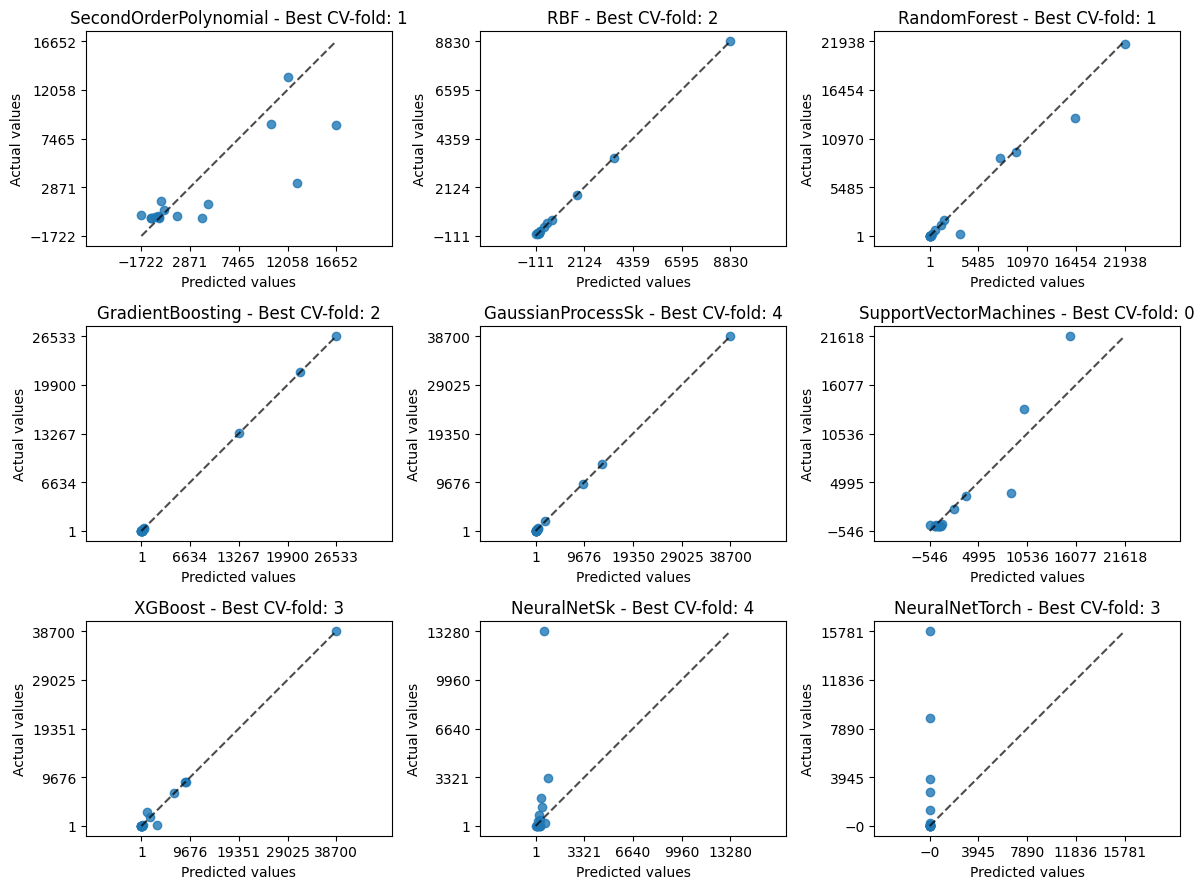

In [5]:
ae.plot_results()

## Evaluating the emulator

Now we can evaluate the best emulator model on the holdout / test set.

In [6]:
ae.evaluate_model(best_model)

,model,rmse,r2
0,RBF,412.632,0.997


And plot the test set predictions.

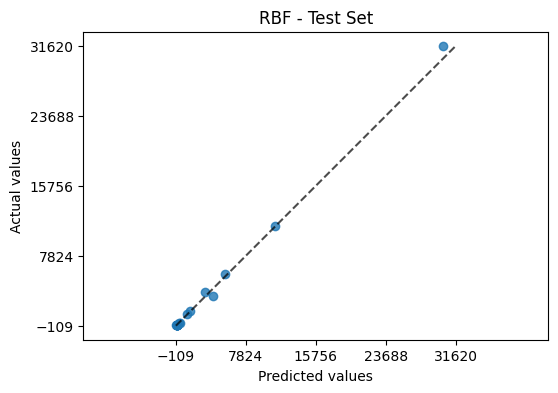

In [7]:
ae.plot_model(best_model)

## Refitting the model on the entire dataset

Before using the emulator model, we usually want to refit it on the entire dataset. This is done with the `refit()` method.

In [ ]:
best_emulator = ae.refit_model(best_model)

## Saving / loading models

Lastly, we can save and load the best model. Note: there are some checks that the environment in which the model is loaded is similar to the environment in which it was saved. These are based on dependencies specified in a _meta.json file which is saved when the model is saved.

In [8]:
# save & load best model
# ae.save_model(best_emulator, "best_model")
# best_emulator = ae.load_model("best_model")

Lastly, we can use the best model to make predictions for new inputs. Emulator models in `AutoEmulate` are `scikit-learn estimators`, so we can use the `predict` method to make predictions. 

In [10]:
# emulate
best_emulator.predict(X[:10])

array([2.79467535e+00, 3.41409191e+00, 9.42172120e+03, 1.81399368e+02,
       3.25695278e+03, 2.16178966e+04, 4.20123626e+01, 1.27298625e+01,
       6.35002638e+02, 7.37074930e+01])